## SMIB-VSG

Single Machine Infinite Bus (SMIB) with VSG from Leon with VSC-L.



### System analysis and simulation

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import pydae.grid_tools as gt
import pydae.ssa as ssa
from IPython.core.display import HTML,SVG
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [10]:
import smib_vsc_l_vsg_ll

#### Initialization

In [11]:
model = smib_vsc_l_vsg_ll.model()

zeta = 0.7 # 1.0/np.sqrt(2) # desired damping
H_v = 4.0  # desired inertia
WB = 2 *np.pi* 50 # base frequency
R_v = 0.0  # virtual resistance (pu-m)
X_v = 0.3  # virtual reactance (pu-m)

Lt = X_v 
P_max = 1/Lt
fn = np.sqrt(WB*P_max/(2*H_v))/(2*np.pi)

# Active power loop
Dp = 0;
K_i = (2*np.pi*fn)**2/(WB*P_max);
K_g = Dp*K_i;
K_p = (2*zeta*2*np.pi*fn - K_g)/(WB*P_max);

# Reactive power loop
T_q = 1.0/(2*np.pi*0.5/2)
K_q = (1.0 - 0.0)/(1.05 - 0.95)
K_i_q = 1e1

# Operating point
p_l_1 = 0.5     # VSG virtual local power reference
v_ref_1 = 1.01  # VSG POI voltage reference
X_s = 0.1 # VSC actual coupling reactance
R_s = 0.0 # VSC actual coupling resistance

params = {"S_n_1":10e6, # VSC nominal power
          'p_l_1':p_l_1,'v_ref_1':v_ref_1, # VSG local references
          'X_s_1':X_s,'R_s_1':R_s,  # VSC actual coupling impedance
          'X_v_1': X_v-X_s, 'R_v_1':R_v-R_s,
          'T_q_1':T_q,'K_q_1':K_q, # Reactive power loop
          'K_i_1':K_i,'K_g_1':K_g,'K_p_1':K_p, # Active power loop
          'b_1_2':-2 # Line susceptance
          }

model.ini(params,'xy_0.json')

p_s_1 = model.get_value('p_s_1')
q_s_1 = model.get_value('q_s_1')
V_1 = model.get_value('V_1')

# Check active and voltage references are achived
tol = 1e-8
assert np.abs(p_l_1 - p_s_1) < tol  # p_s
assert np.abs(v_ref_1 - V_1) < tol  # V_s

# Check dq magnitudes are correct
delta = model.get_value('delta_1')
q_s = model.get_value('q_s_1')
V_s = model.get_value('V_1')
i_sr = model.get_value('i_sr_1')  
i_si = model.get_value('i_si_1')  

#v_sd = v_si * np.cos(delta) - v_sr * np.sin(delta)   
#v_sq = v_si * np.sin(delta) + v_sr * np.cos(delta)
i_sd_exp = i_si * np.cos(delta) - i_sr * np.sin(delta)   
i_sq_exp = i_si * np.sin(delta) + i_sr * np.cos(delta)

i_sd = model.get_value('i_sd_1')  
i_sq = model.get_value('i_sq_1') 

assert np.abs(i_sd_exp - i_sd) < tol  # i_sd
assert np.abs(i_sq_exp - i_sq) < tol  # i_sq

# Check virtual impedance
e_vd = 0.0
e_vq = model.get_value('e_vq_1')
R_v = model.get_value('R_v_1')
X_v = model.get_value('X_v_1')
v_td_exp = e_vd - R_v*i_sd_exp - X_v*i_sq_exp   
v_tq_exp = e_vq - R_v*i_sq_exp + X_v*i_sd_exp   

v_td = model.get_value('v_td_ref_1')
v_tq = model.get_value('v_tq_ref_1')

assert np.abs(v_td_exp - v_td) < tol  # v_td
assert np.abs(v_tq_exp - v_tq) < tol  # v_tq

# Check control output to the VSC input (m,theta)
v_dc = model.get_value('v_dc_1')
m_exp = np.sqrt(v_td_exp**2 + v_tq_exp**2)/v_dc

v_ti_exp =  v_td_exp * np.cos(delta) + v_tq_exp * np.sin(delta)   
v_tr_exp = -v_td_exp * np.sin(delta) + v_tq_exp * np.cos(delta) 

theta_t_exp = np.arctan2(v_ti_exp,v_tr_exp)
theta_t = model.get_value('theta_t_1')

assert np.abs(theta_t_exp - theta_t) < tol  

# Check dynamic
ssa.A_eval(model)
damp = ssa.damp_report(model)
assert  damp.sort_values('Damp').round(2)['Damp'][0] > 0.0
assert  np.abs(damp.sort_values('Damp').round(2)['Damp'][0] - zeta) < 1e-1

AssertionError: 

#### Small signal analysis

In [4]:
ssa.A_eval(model)
damp = ssa.damp_report(model)
damp.sort_values('Damp').round(2)

,Real,Imag,Freq.,Damp
Mode 4,-8.23,8.25,1.31,0.71
Mode 5,-8.23,-8.25,1.31,0.71
Mode 1,-1.00,0.00,0.00,1.00
Mode 2,-0.01,0.00,0.00,1.00
Mode 3,-50.11,0.00,0.00,1.00
Mode 6,-0.00,0.00,0.00,1.00
Mode 7,-0.00,0.00,0.00,1.00
Mode 8,-0.00,0.00,0.00,1.00
Mode 9,-0.00,0.00,0.00,1.00


In [5]:
ssa.participation(model).abs().round(2)

,Mode 1,Mode 2,Mode 3,Mode 4,Mode 5,Mode 6,Mode 7,Mode 8,Mode 9
m_f_1,1.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0
delta_1,0.0,0.0,0.02,0.72,0.72,0.0,0.0,0.0,0.0
x_v_1,0.0,0.0,0.00,0.71,0.71,0.0,0.0,0.0,0.0
e_qm_1,0.0,0.0,1.02,0.01,0.01,0.0,0.0,0.0,0.0
xi_v_1,0.0,0.0,0.00,0.00,0.00,1.0,0.0,0.0,0.0
delta_2,0.0,0.0,0.00,0.00,0.00,0.0,1.0,0.0,0.0
Domega_2,0.0,0.0,0.00,0.00,0.00,0.0,0.0,1.0,0.0
Dv_2,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,1.0
xi_freq,0.0,1.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0


#### Time domain simulation

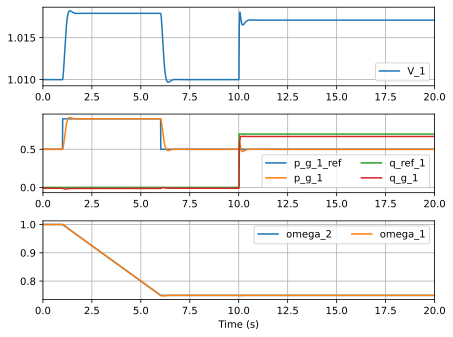

In [6]:
model = smib_vsc_l_vsg_ll.model()
model.Dt = 0.01
model.decimation = 1
model.ini(params,'xy_0.json')
model.run( 1.0,{})
model.run(6.0,{'alpha_2':-0.05})
model.run(10.0,{'alpha_2':0.0})
model.run(30.0,{'q_r_1':0.7})
model.post();

fig,axes = plt.subplots(nrows=3)

axes[0].plot(model.Time,  model.get_values('V_1'),label='V_1')

alpha_2 = model.get_values('alpha_2') 
p_s_1_0 = model.get_values('p_s_1')[0]
axes[1].plot(model.Time,  -2*H_v*alpha_2 + p_s_1_0,label='p_g_1_ref')
axes[1].plot(model.Time,  model.get_values('p_s_1'),label='p_g_1')

axes[1].plot(model.Time,  model.get_values('q_ref_1'),label='q_ref_1')
axes[1].plot(model.Time,  model.get_values('q_s_1'),label='q_g_1')

axes[2].plot(model.Time,  model.get_values('omega_2'),label='omega_2')
axes[2].plot(model.Time,  model.get_values('omega_v_1'),label='omega_1')

for ax in axes:
    ax.legend(ncol=2)
    ax.grid()
    ax.set_xlim([0,20])
ax.set_xlabel('Time (s)')
fig.tight_layout()


In [7]:
model.report_y()

V_1   =  1.02
theta_1 = -0.01
V_2   =  1.00
theta_2 =  0.00
i_si_1 = -0.66
i_sr_1 =  0.49
p_s_1 =  0.50
q_s_1 =  0.67
p_dc_1 =  0.51
v_td_ref_1 = -0.08
v_tq_ref_1 =  1.08
e_vq_1 =  1.22
m_1   =  0.90
theta_t_1 =  0.04
omega_2 =  0.75
i_d_2 = -0.07
i_q_2 = -0.05
p_s_2 = -0.05
q_s_2 = -0.07
omega_coi =  0.75
p_agc =  0.00
